In [1]:
# Initialization of packaging and figure looking in matplotlib
# the tools module contains costum set of functions for GP interpolation

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from cobaya.run import run
from cobaya.yaml import yaml_load_file
import seaborn as sns
from getdist import  loadMCSamples, MCSamples
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt
import os, sys

colors = ["#003049","#d62828", "#f77f00", "#fcbf49",'#eae2b7']
cpal= sns.color_palette(colors)

plt.rcParams['mathtext.default']= 'regular'
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams["axes.labelpad"]=10   # axes labels distance from tick labels
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
rc('text',usetex=False)           # use LaTex for plot texts plt.rcParams['figure.dpi'] = 100  #  figure dimension in dpi
plt.rcParams['figure.dpi'] = 150




In [28]:
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'../CAMB/'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

#import SNIA data files 

zsn,zhel,mb,dmb = np.loadtxt('data/lcparams_full_long_zhel.txt',usecols=(1,2,4,5),unpack=True)
cov = np.loadtxt('data/sys_full_long.txt',unpack=True,skiprows=1)

cov = np.reshape(cov,(1048,1048))

Using CAMB 1.3.5 installed at /data1/renzi/CAMB/camb


In [29]:
pars = camb.set_params(H0=70,ombh2=0.0224,omch2=0.12)

results = camb.get_background(pars)

dL = results.luminosity_distance

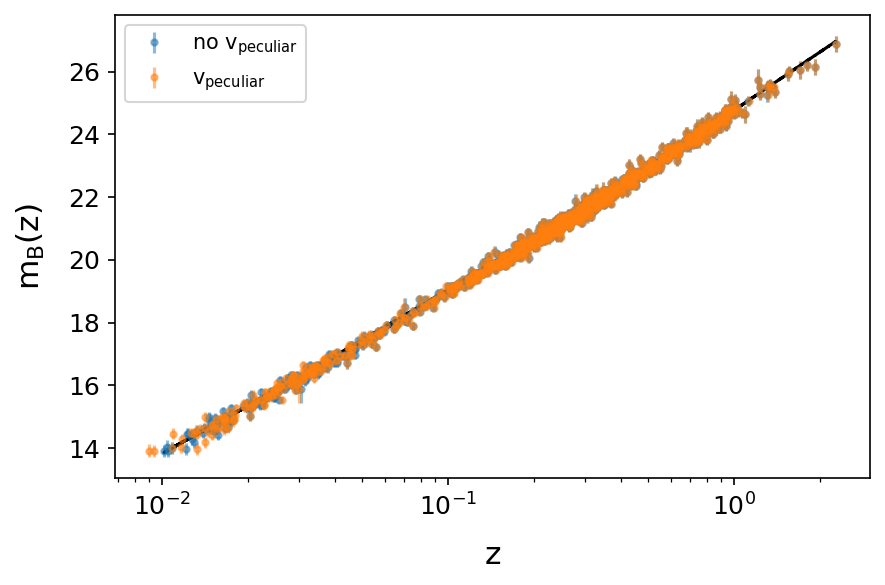

In [30]:
plt.figure()
plt.errorbar(zsn,mb,dmb,fmt='.',alpha=0.5,label=r'no $v_{\rm peculiar}$ ')
plt.errorbar(zhel,mb,dmb,fmt='.',alpha=0.5,label=r'$v_{\rm peculiar}$ ')

plt.plot(zsn,5*np.log10(70*dL(zsn)) -0.7127*5,'--k')
plt.xlabel("$z$")
plt.ylabel("$m_B(z)$")

plt.xscale('log')


plt.tight_layout()

plt.legend()


In [31]:

zfacsq = 25.0 / np.log(10.0) ** 2
pecz = 0.001

pre_vars = dmb**2. + zfacsq * pecz ** 2 * ((1.0 + zsn) / (zsn * (1 + 0.5 * zsn))) ** 2

delta = pre_vars

np.fill_diagonal(cov, cov.diagonal() + delta)

inv_cov = np.linalg.inv(cov)

def lnlike(_self=None):
    
    invvars = 1.0 / pre_vars
    wtval = np.sum(invvars)

    da = _self.provider.get_angular_diameter_distance
    
    lumdist = (5 * np.log10((1 + zhel) * (1 + zsn)) * da(zsn))
    estimated_scriptm = np.sum((mb - lumdist) * invvars) / wtval
    diffmag = mb - lumdist - estimated_scriptm
    
    invvars = inv_cov.dot(diffmag)
    amarg_A = invvars.dot(diffmag)

    amarg_B = np.sum(invvars)
    amarg_E = np.sum(inv_cov)

    chi2 = amarg_A + np.log(amarg_E / 2./np.pi) - amarg_B ** 2 / amarg_E
                  
    return -0.5*np.sum(chi2)


In [ ]:
info = {'likelihood': {'sn_pantheon': {
        "external": lnlike,
        # Declare required quantities!
        "requires": {'angular_diameter_distance': {'z': zsn}},
        }},
 'params': {
            'H0': {'latex': 'H_0',
                   'prior': {'max': 80, 'min': 50},
                   'proposal': 0.01,
                   'ref': {'dist': 'norm', 'loc': 67, 'scale': 2}},
            'YHe': 0.245341,
            'mnu': 0.06,
            'ombh2': {'latex': '\\Omega_\\mathrm{b} h^2',
                      'prior': {'dist': 'norm', 'loc': 0.0222, 'scale': 0.0005},
                      'proposal': 0.0004,
                      'ref': {'dist': 'norm', 'loc': 0.0222, 'scale': 0.0005}},
            'omch2': {'latex': '\\Omega_\\mathrm{c} h^2',
                      'prior': {'max': 0.99, 'min': 0.001},
                      'proposal': 0.002,
                      'ref': {'dist': 'norm', 'loc': 0.12, 'scale': 0.003}},
            'omega_de': {'latex': '\\Omega_\\Lambda'},
            'omegam': {'latex': '\\Omega_\\mathrm{m}'},
            'omegamh2': {'derived': 'lambda omegam, H0: omegam*(H0/100)**2',
                         'latex': '\\Omega_\\mathrm{m} h^2'}},
 'sampler': {'mcmc': {'max_tries':1000}},
 'theory': {'camb': {'extra_args': {'nnu': 3.046, 'num_massive_neutrinos': 1,}}},
 'stop_at_error': True    
       }
       
updated_info,sampler = run(info)

[CAMB] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
[sn_pantheon] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {sn_pantheon: 680.0, camb.transfers: 47.1, camb: 1990.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: H0:68.09493, ombh2:0.02300897, omch2:0.1223143
[mcmc] Sampling!
[mcmc] Progress @ 2022-04-08 14:03:43 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.565
[mcmc]  - Convergence of means: R-1 = 25.836775 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


In [ ]:
from getdist.mcsamples import MCSamples

gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"],settings={'ignore_rows': 0.3})

import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample,['omegam','omega_de'] ,filled=True,title_limit=1)

# Create Yaml Files for parallel runnings 

We explore three models ($\Lambda$CDM, wCDM, oCDM) to check that our likelihood reproduces pantheon published results (https://arxiv.org/abs/1710.00845)

- $\Lambda$CDM : $\quad \Omega_m = 0.300 \pm 0.022$


- oCDM : $\quad \Omega_m = 0.319 \pm 0.070$ $\quad \Omega_k = 0.319 \pm 0.070$


- wCDM : $\quad \Omega_m = 0.316 \pm 0.072\quad$ $w = -1.090 \pm 0.220$


In [14]:
# We recreate the info dictionary but this time we dump it into a yaml file for later use
# with some easy substitutions we modify the dictionary to obtain wCDM and oCDM inputs
# These files have to be called externally through "cobaya-run file_name"

info = {'likelihood': {'SNIaCostumLike.pantheonCostum': {'python_path' : './'}},
 'params': {
            'H0': {'latex': 'H_0',
                   'prior': {'max': 80, 'min': 50},
                   'proposal': 0.01,
                   'ref': {'dist': 'norm', 'loc': 67, 'scale': 2}},
            'YHe': 0.245341,
            'mnu': 0.06,
            'ombh2': {'latex': '\\Omega_\\mathrm{b} h^2',
                      'prior': {'dist': 'norm', 'loc': 0.0222, 'scale': 0.0005},
                      'proposal': 0.0004,
                      'ref': {'dist': 'norm', 'loc': 0.0222, 'scale': 0.0005}},
            'omch2': {'latex': '\\Omega_\\mathrm{c} h^2',
                      'prior': {'max': 0.99, 'min': 0.001},
                      'proposal': 0.002,
                      'ref': {'dist': 'norm', 'loc': 0.12, 'scale': 0.003}},
            'omega_de': {'latex': '\\Omega_\\Lambda'},
            'omegam': {'latex': '\\Omega_\\mathrm{m}'},
            'omegamh2': {'derived': 'lambda omegam, H0: omegam*(H0/100)**2',
                         'latex': '\\Omega_\\mathrm{m} h^2'}},
 'sampler': {'mcmc': ''},
 'theory': {'camb': {'extra_args': {'nnu': 3.046, 'num_massive_neutrinos': 1,}}},
 'stop_at_error': True      
       }

update_runs = [{'output':''},{'params':{'w': {'latex': 'w_\\mathrm{DE}',
                  'prior': {'max': -0.333, 'min': -3},
                  'proposal': 0.02,
                  'ref': {'dist': 'norm', 'loc': -0.99, 'scale': 0.02}}}},
               {'params':{'omk': {'latex': '\\Omega_k',
                    'prior': {'max': 0.3, 'min': -0.3},
                    'proposal': 0.001,
                    'ref': {'dist': 'norm', 'loc': -0.009, 'scale': 0.001}}}}
              ]


In [13]:
import yaml

for i,name in zip(update_runs,['LCDM','wCDM','oCDM']):
    _info = info.copy()
    _info.update(i)
    
    _info['output']= 'chains/Pantheon_'+name

    with open('Pantheon_SNIa_'+name+'.yaml','w') as outfile:
         yaml.dump(_info,outfile,default_flow_style=False)

# Plotting the various results for comparison

[root] *WARNING* auto bandwidth for chi2 very small or failed (h=0.0010232518432284536,N_eff=531.5013024903616). Using fallback (h=0.005806546533166409)


<Figure size 1200x900 with 0 Axes>

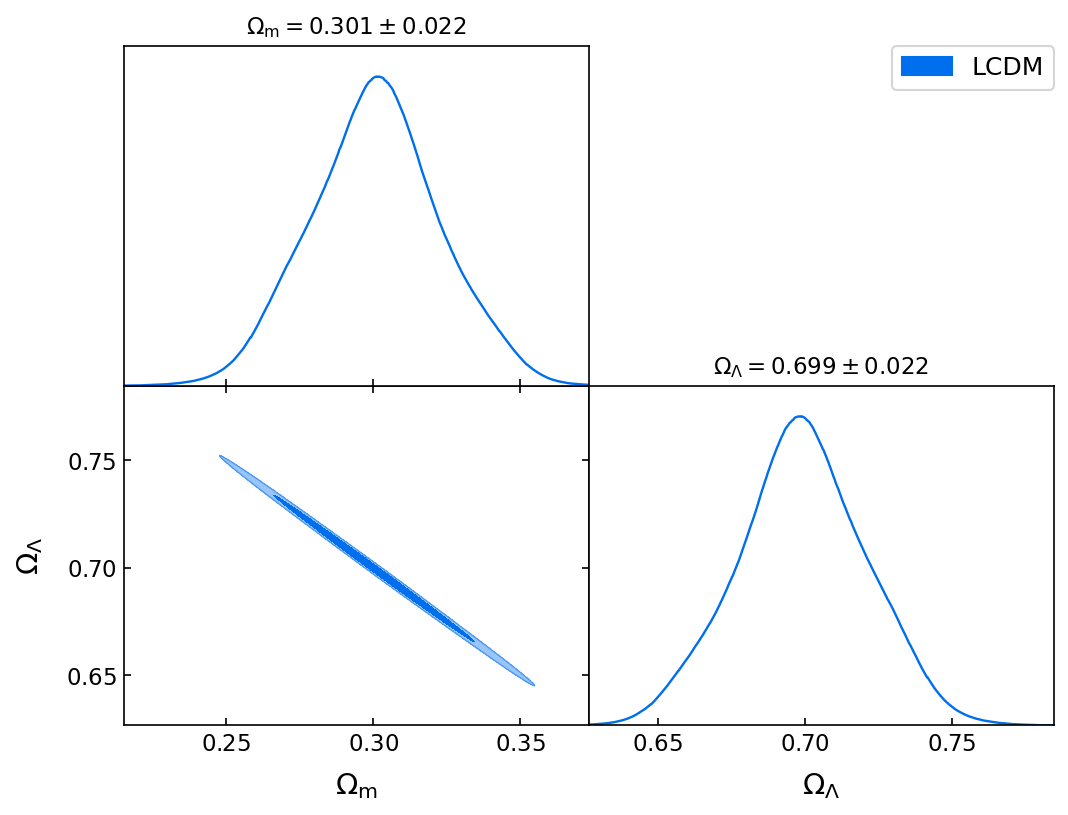

In [38]:
from getdist import loadMCSamples
import getdist.plots as gdplt

fname = [
         'Pantheon_LCDM',
         #'Pantheon_wCDM',
         #'Pantheon_oCDM',
        ]

labels = [fn.split('_')[-1] for fn in fname]

params = ['omegam','omega_de']
colors = sns.hls_palette(4,h=.4,l=.4,s=1).as_hex()


samples = [loadMCSamples('./chains/'+x,settings={'ignore_rows': 0.3}) for x in fname]

g = gdplt.get_single_plotter(width_inch=8)
g.triangle_plot(samples,params, legend_labels=labels, 
                markers={'omegam':0.3,'w':-1,'omk':0},filled=True,title_limit=1);

